In [28]:
%load_ext autoreload
%autoreload 2
import sys 
if '/Users/ericliu/Desktop/Latent-Dirichilet-Allocation' not in sys.path: 
    sys.path.append('/Users/ericliu/Desktop/Latent-Dirichilet-Allocation')
import torch as tr 
import numpy as np 
import pandas as pd 
from collections import defaultdict
from pprint import pprint
import matplotlib.pyplot as plt 

from sklearn.decomposition import LatentDirichletAllocation 
from tuotuo.lda_model import LDASmoothed 
from tuotuo.generator import doc_generator 
from tuotuo.utils import (
    get_vocab_from_docs, 
    get_np_wct, 
    data_loader,
    text_pipeline, 
    process_documents,
    compute_elbo,
) 
from tuotuo.text_pre_processor import (
    remove_accented_chars, 
    remove_special_characters, 
    remove_punctuation,
    remove_extra_whitespace_tabs,
    remove_stopwords,
)
from pprint import pprint 
import copy  

from tuotuo.cutils import (
    _dirichlet_expectation_1d, 
    _dirichlet_expectation_2d,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Document Generation

In [29]:
gen = doc_generator(
    M = 100,
    L = 20, 
    topic_prior = tr.tensor([1,1,1,1,1], dtype=tr.double)
)

In [30]:
gen.alpha

Dirichlet(concentration: torch.Size([5]))

In [31]:
gen.theta.shape

torch.Size([100, 5])

In [32]:
#gen.theta

In [33]:
docs = gen.generate_doc()

In [34]:
#docs_raw_dict, raw_word_2_idx, raw_idx_2_word = data_loader('ap')

In [35]:
result = process_documents(docs, sample=True)

There are 100 documents in the dataset after processing
On average estimated document length is 10.0 words per document after processing
There are 40 unique vocab in the corpus after processing


In [36]:
print(result.keys())

dict_keys(['documents', 'vocab_doc_count_dict', 'vocab_doc_count_array', 'vocab_to_idx', 'idx_to_vocab'])


In [37]:
doc_vocab_count = np.zeros(
    (
        len(docs), len(result['vocab_to_idx'])
    ),
    dtype = float,
)

for doc_idx, doc in enumerate(result['documents']): 
    for word in doc: 
        vocab_idx = result['vocab_to_idx'][word]
        doc_vocab_count[doc_idx, vocab_idx] += 1 

print(doc_vocab_count.shape)

(100, 40)


In [38]:
doc_vocab_count_df = pd.DataFrame(
    data = doc_vocab_count,
    columns = list(result['vocab_to_idx'].keys())
)
doc_vocab_count_df

,accuse,evidence,bruise,FIFA,Craftsmanship,picture,court,Technique,astrophysics,immunology,...,exercise,appetite,energy,football,injection,game,allergy,Symmetrical,decongestant,athletics
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
96,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
97,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
98,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,1.0,0.0


# Our Model

Topic Dirichlet Prior, Alpha
1

Exchangeable Word Dirichlet Prior, Eta 
1

Var Inf - Word Dirichlet prior, Lambda
(5, 40)

Var Inf - Topic Dirichlet prior, Gamma
(100, 5)

Size of the vocab is 40
Init perplexity = 98.58226277506884
End perplexity = 50.540589733975764


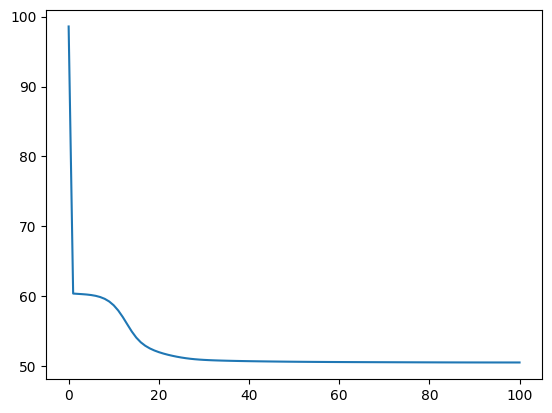

In [39]:
lda = LDASmoothed(
    docs = result['documents'],
    num_topics = 5, 
    word_ct_dict = result['vocab_doc_count_dict'], 
    num_doc_population = 100,
    word_ct_array = result['vocab_doc_count_array'],
)
print(f'Size of the vocab is {lda.V}')
lambda_init = lda._lambda_ 

perplexes = lda.partial_fit(
    X = doc_vocab_count,
    sampling= False,
    verbose=True, 
    return_perplexities=True,
)

plt.plot(perplexes)

In [40]:
lda.idx_2_word

{0: 'accuse',
 1: 'evidence',
 2: 'bruise',
 3: 'FIFA',
 4: 'Craftsmanship',
 5: 'picture',
 6: 'court',
 7: 'Technique',
 8: 'astrophysics',
 9: 'immunology',
 10: 'divorce',
 11: 'attorney',
 12: 'contract',
 13: 'bankrupt',
 14: 'Olympic',
 15: 'asymmetrical',
 16: 'form',
 17: 'recreation',
 18: 'content',
 19: 'genetics',
 20: 'research',
 21: 'concert',
 22: 'quantum',
 23: 'scientst',
 24: 'electricity',
 25: 'fever',
 26: 'physical',
 27: 'contagious',
 28: 'infection',
 29: 'copyright',
 30: 'exercise',
 31: 'appetite',
 32: 'energy',
 33: 'football',
 34: 'injection',
 35: 'game',
 36: 'allergy',
 37: 'Symmetrical',
 38: 'decongestant',
 39: 'athletics'}

In [41]:
lda._lambda_[0,30]

21.407206305103696

- As we can see, without update the hyper-parameter $\alpha$ and $\eta$, we extract keywords from topics almost correctly. 

Although we still can see that some are not perfect, i.e. electricity ranked higher than scientist 

In [42]:
for topic_index in range(lda._lambda_.shape[0]):

    top5 = np.argsort(lda._lambda_[topic_index,:],)[-5:]
    print(f"Topic {topic_index}")
    for i, idx in enumerate(top5):
        print(f"Top {i+1} -> {lda.idx_2_word[idx]}")
    print()

Topic 0
Top 1 -> Craftsmanship
Top 2 -> Technique
Top 3 -> exercise
Top 4 -> FIFA
Top 5 -> content

Topic 1
Top 1 -> copyright
Top 2 -> contract
Top 3 -> attorney
Top 4 -> accuse
Top 5 -> divorce

Topic 2
Top 1 -> immunology
Top 2 -> genetics
Top 3 -> quantum
Top 4 -> astrophysics
Top 5 -> infection

Topic 3
Top 1 -> electricity
Top 2 -> Symmetrical
Top 3 -> concert
Top 4 -> asymmetrical
Top 5 -> picture

Topic 4
Top 1 -> contagious
Top 2 -> appetite
Top 3 -> injection
Top 4 -> decongestant
Top 5 -> allergy



# Target model

alpha -> 1
eta -> 1
lambda
(5, 40)
Init perplexity = 96.88781201053929
End perplexity = 50.53892348630458


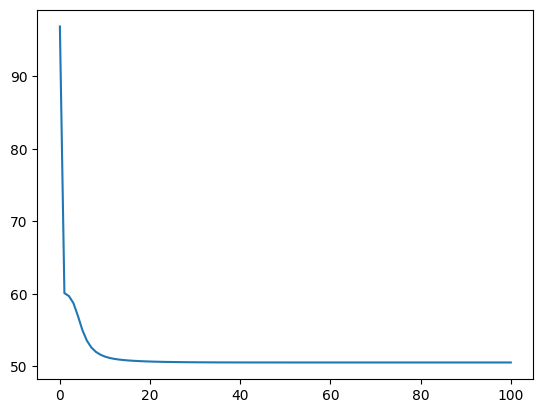

In [43]:
sklearn_lda = LatentDirichletAllocation(
    n_components=5,
    random_state=42,
    doc_topic_prior= 1,
    topic_word_prior= 1,
)
sklearn_lda._init_latent_vars(n_features = lda.V)

print(f"alpha -> {sklearn_lda.doc_topic_prior}")
print(f"eta -> {sklearn_lda.topic_word_prior}")

print('lambda')
print(sklearn_lda.components_.shape)
assert (sklearn_lda.components_ == lambda_init).all()

perplxities_sklearn = []
init_perplexity = sklearn_lda._perplexity_precomp_distr(
    doc_vocab_count, 
    doc_topic_distr = lda._gamma_,
    sub_sampling=False
)
print(f"Init perplexity = {init_perplexity}")
perplxities_sklearn.append(init_perplexity)

for i in range(100):
    
    sklearn_lda._em_step(doc_vocab_count, doc_vocab_count.shape[0], True, )

    em_step_perplexity = sklearn_lda.perplexity(doc_vocab_count)
    #print(f"{i+1} EM step perplexity is {em_step_perplexity}")
    perplxities_sklearn.append(em_step_perplexity)
print(f"End perplexity = {perplxities_sklearn[-1]}")
plt.plot(perplxities_sklearn)